## Disaster Tweet classifiaction

**Maintained by:** [Manan Paneri](https://github.com/manan-paneri-99)

* NLP, Tensorflow, Tensorflow Hub

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1YaJu7BC72DJk0RTq26FTaWIMVumVUuZv?usp=sharing)

### 1. Setup

In [ ]:
!nvidia-smi

Fri Feb  5 17:07:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q tensorflow-text

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text

import matplotlib.pyplot as plt

import pathlib
import shutil
import tempfile

tf.get_logger().setLevel('ERROR')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Loading the data

Link to data repository : [Data](https://drive.google.com/drive/folders/1-De_MJQftD33OK_ZY3orOHAnTh3LMfG4?usp=sharing)

Change the data_path to: 'content/drive/Shareddrive/data'

In [ ]:
data_path = '/content/drive/MyDrive/Kaggle/Natural Language Processing with Disaster Tweets/data'

In [ ]:
df = pd.read_csv(data_path + '/train.csv', low_memory=False)
df.shape
df.head(8)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1


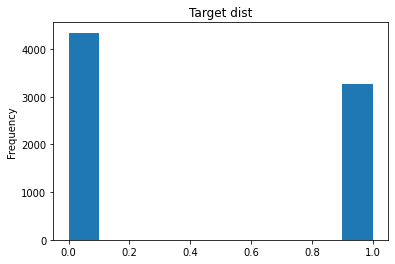

In [ ]:
df['target'].plot(kind = 'hist', title= 'Target dist')

### 3. Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, random_state=43, train_size=0.8)
print(train_df.shape)
print(valid_df.shape)

(6090, 5)
(1523, 5)


### 4. Building model parts

In [2]:
models = ['bert_en_uncased_L-12_H-768_A-12', 'bert_en_uncased_L-24_H-1024_A-16',
          'bert_en_cased_L-12_H-768_A-12']
preprocessors = ['https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', 
                 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
                 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3']
modules = ['https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3', 
           'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
           'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3']

In [ ]:
preprocessor_url = preprocessors[2]
module_url = modules[2]

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocessor_url)

### 5. Creating the model

In [ ]:
def train_and_evaluate_model():
  text_input = tf.keras.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocessor_url, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(module_url, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  #net = tf.keras.layers.Dense(128, activation='relu')(net)
  net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name= 'classifier')(net)
  return tf.keras.Model(text_input, net)



In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
#steps_per_epoch = tf.data.experimental.cardinality(train_df).numpy()
#num_train_steps = steps_per_epoch * epochs
#num_warmup_steps = int(0.1*num_train_steps)

int_lr = 3e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=int_lr)

In [ ]:
classifier_model = train_and_evaluate_model()
classifier_model.compile(optimizer=optimizer, loss =loss, metrics=metrics)

In [ ]:
histories = {}

### 6. Training the model

In [ ]:
print('Training model with')
histories[models[2]] = classifier_model.fit(train_df['text'], train_df['target'], 
                                       validation_data=(valid_df['text'], valid_df['target']),
                                       epochs=epochs)

Training model with
Epoch 1/5
191/191 [==============================] - 194s 957ms/step - loss: 0.5675 - binary_accuracy: 0.7103 - val_loss: 0.4032 - val_binary_accuracy: 0.8221
Epoch 2/5
191/191 [==============================] - 185s 968ms/step - loss: 0.3203 - binary_accuracy: 0.8740 - val_loss: 0.4171 - val_binary_accuracy: 0.8345
Epoch 3/5
191/191 [==============================] - 185s 966ms/step - loss: 0.2010 - binary_accuracy: 0.9252 - val_loss: 0.4932 - val_binary_accuracy: 0.8339
Epoch 4/5
191/191 [==============================] - 185s 968ms/step - loss: 0.1219 - binary_accuracy: 0.9570 - val_loss: 0.5603 - val_binary_accuracy: 0.8306
Epoch 5/5
191/191 [==============================] - 184s 965ms/step - loss: 0.1027 - binary_accuracy: 0.9623 - val_loss: 0.6074 - val_binary_accuracy: 0.8247


In [ ]:
test_df = pd.read_csv(data_path + '/test.csv', low_memory=False)
test_df.shape
test_df.head(6)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake


In [ ]:
test = test_df['text']
test

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [ ]:
results = classifier_model.predict(test_df['text'])

### 7. Test and evaluate

In [ ]:
threshold =0.5
results = np.where(results > threshold, 1, 0)
results

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


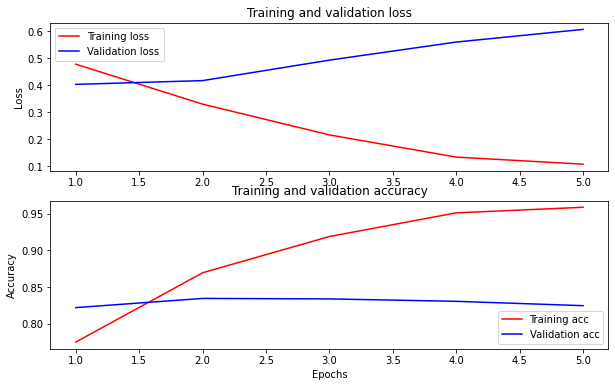

In [ ]:
history_dict = histories[models[2]].history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
Y_test = results
df_submission = pd.read_csv(data_path + '/sample_submission.csv', index_col=0).fillna(' ')
df_submission['target'] = Y_test
df_submission

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,0
10865,1
10868,1
